In [159]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from datascience import Table

# Exploration

In [162]:
patients = Table.read_table('/home/jovyan/work/datasets/breast-cancer-wisconsin.csv', dtype=np.int32).drop('id')
patients

thickness,size_uniformity,shape_uniformity,adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
5,1,1,1,2,1,3,1,1,2
5,4,4,5,7,10,3,2,1,2
3,1,1,1,2,2,3,1,1,2
6,8,8,1,3,4,3,7,1,2
4,1,1,3,2,1,3,1,1,2
8,10,10,8,7,10,9,7,1,4
1,1,1,1,2,10,3,1,1,2
2,1,2,1,2,1,3,1,1,2
2,1,1,1,2,1,1,1,5,2
4,2,1,1,2,1,2,1,1,2


In [163]:
# patients.scatter('bland_chromatin', 'epithelial_size', colors ='class')

Voodoo to make the plot look a little better ...

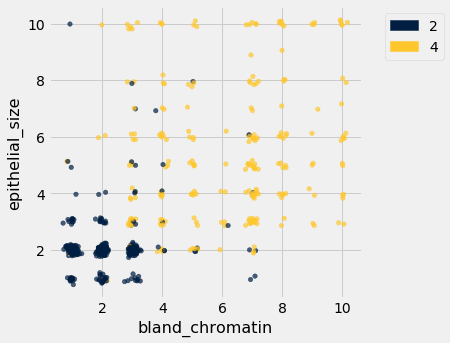

In [164]:
def randomize_columns(a):
    return a + np.random.normal(0.0,0.09,size=len(a))

jittered = Table().with_columns([
    'bland_chromatin', 
    randomize_columns(patients.column('bland_chromatin')),
    'epithelial_size', 
    randomize_columns(patients.column('epithelial_size')),
    'class',
    patients.column('class')
])

jittered.scatter('bland_chromatin', 'epithelial_size', colors ='class')

# Figuring Out The Distance

So how do we figure out the distance? Well - how would we do that in two dimensions?

###  PYTHAGORAS, MY BOY

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Pythagorean.svg/1920px-Pythagorean.svg.png width="500">

AKA Euclidean Distance - we can calculate the linear distance between many points like so:

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/e99e0fc30fad6a8422c82be9df69677a24b1ac72)

<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/e99e0fc30fad6a8422c82be9df69677a24b1ac72 width="500">


In [167]:
def distance(pt1, pt2):
    return np.sqrt(sum((pt1 - pt2) ** 2))
    
def row_distance(row1,row2):
    return distance( np.array(row1),  np.array(row2))

Let's look at some of the data and see if it works as we're expecting...

In [168]:
attributes = patients.drop('class')
attributes.show(3)

thickness,size_uniformity,shape_uniformity,adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis
5,1,1,1,2,1,3,1,1
5,4,4,5,7,10,3,2,1
3,1,1,1,2,2,3,1,1


In [169]:
row_distance(attributes.row(0),attributes.row(1))

11.874342087037917

In [170]:
row_distance(attributes.row(0),attributes.row(2))

2.23606797749979

In [171]:
row_distance(attributes.row(0),attributes.row(0))

0.0

# Doing this for lots of points...
So we know we can compare two points. We want to find the nearest neighbor right? That means we need to compare one point against the _rest_ of the points...

In [173]:
def distances(training, example):
    dists = []
    attributes = training.drop('class')
    for row in attributes.rows:
        dist = row_distance(row, example)
        dists.append(dist)
    return training.with_column('distance',dists)

We want to find the top `k` nearest neighbors ...

In [68]:
def closest(training, example, k):
    return distances(training, example).sort('distance').take(np.arange(k))

In [79]:
patients.take(9)

thickness,size_uniformity,shape_uniformity,adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
4,2,1,1,2,1,2,1,1,2


In [174]:
example = patients.drop('class').row(15)
example

Row(thickness=7, size_uniformity=4, shape_uniformity=6, adhesion=4, epithelial_size=6, bare_nuclei=1, bland_chromatin=4, normal_nucleoli=3, mitosis=1)

In [175]:
closest(patients.exclude(15), example, 5)

thickness,size_uniformity,shape_uniformity,adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class,distance
8,4,6,3,3,1,4,3,1,2,3.31662
5,3,4,1,4,1,3,1,1,2,5.19615
5,4,5,1,8,1,3,6,1,2,5.2915
8,2,4,1,5,1,5,4,4,4,5.47723
9,5,5,4,4,5,4,3,3,4,5.47723


Let's do that with some code ...

In [87]:
def majority_class(neighbors):
    return neighbors.group('class').sort('count', descending=True).column('class').item(0)

def classify(training, example, k):
    nearest_neighbors = closest(training, example, k)
    return majority_class(nearest_neighbors)

In [178]:
classify(patients.exclude(15), example, 5)

2

# Accuracy

In [179]:
patients.num_rows

683

In [181]:
shuffled = patients.sample(with_replacement=False)

trainset = shuffled.take(range(0,342))
testset = shuffled.take(range(342, 683))

def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('class')
    numcorrect = 0
    for i in range(test.num_rows):
        test_patient = test_attributes.row(i)
        c = classify(training, test_patient, k)
        if c == test.column('class').item(i):
            numcorrect = numcorrect + 1
    return numcorrect / test.num_rows

In [182]:
evaluate_accuracy(trainset,testset,5)

0.9706744868035191

In [183]:
evaluate_accuracy(trainset,testset,1)

0.9648093841642229

In [184]:
evaluate_accuracy(trainset,trainset,5)

0.9883040935672515

In [185]:
evaluate_accuracy(trainset,trainset,1)

1.0

# Decision Boundaries

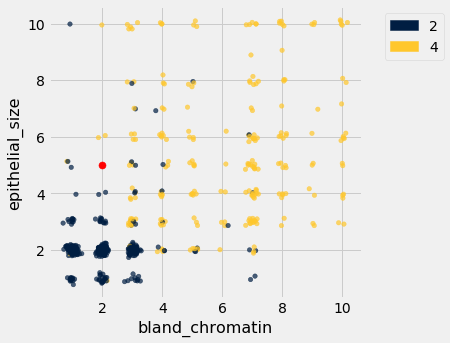

In [200]:
def show_closest(t, point):
    near = closest(t, point, 1).row(0)
    t.scatter(0,1,colors='class')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot([point.item(0), near.item(0)], [point.item(1), near.item(1)],color='k',lw=2)

patients_ce = jittered.select('bland_chromatin', 'epithelial_size', 'class')
patients_ce.scatter('bland_chromatin', 'epithelial_size', colors=2)
plt.scatter(2,5,color='red',s=50)

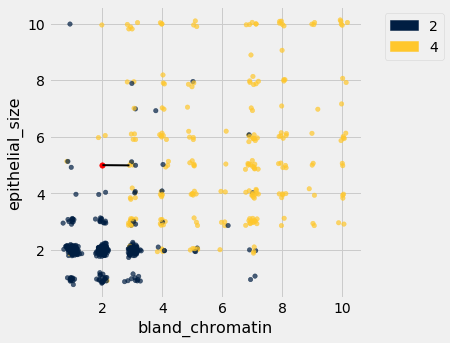

In [201]:
show_closest(patients_ce, np.array([2,5]))

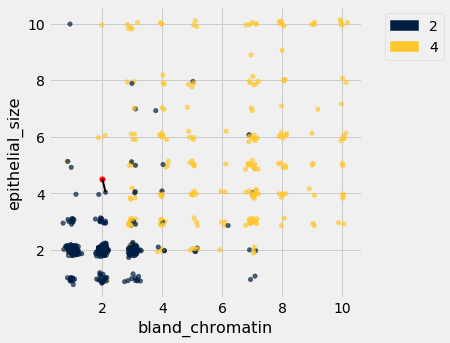

In [205]:
show_closest(patients_ce, np.array([2,4.5]))

## Playing with `k`

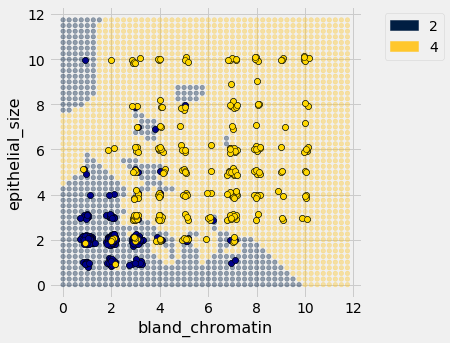

In [216]:
def decision_boundary(t,k):
    t_su = t
    decisions = Table(t.labels)
    for x in np.arange(0,12,0.25):
        for y in np.arange(0, 12,0.25):
            predicted = classify(t,np.array([x,y]),k)
            decisions.append([x,y,predicted])
    decisions.scatter(0,1,colors='class',alpha=0.4)
#     plt.xlim(0,10)
#     plt.ylim(0,10)
    plt.scatter(t.column(0),t.column(1), edgecolor='k')
    t_2 = t_su.where('class',2)
    t_4 = t_su.where('class',4)
    plt.scatter(t_2.column(0),t_2.column(1), c='darkblue', edgecolor='k')
    plt.scatter(t_4.column(0),t_4.column(1), c='gold', edgecolor='k')

decision_boundary(jittered, 1)

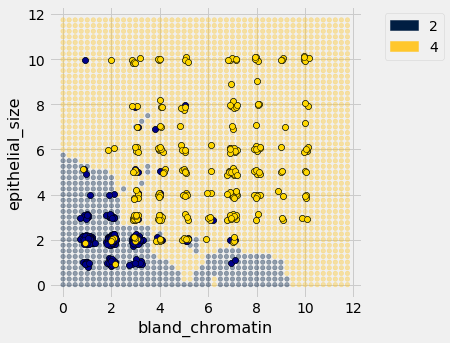

In [217]:
decision_boundary(jittered, 5)